# Mixtral 8X22B Tutorial

## Introduction

When OpenAI released ChatGPT in 2022, many wondered if other companies could ever compete with such a good product backed by a behemoth like Microsoft. When everyone had their attention on other large techies such as Google and Meta to deliver, out came Mistral AI with their 7B model in 2023, which outperformed all open-source LLMs with almost twice the size. 

Since then, Mistral AI became a _big player_ in the LLM race that is happening at breakneck speed. In April 2024, they released Mixtral 8X22B, a model that easily outperformed then-best open-source Llama 2 on many benchmarks. In this tutorial, we will discuss the model in detail from architecture to setting up a RAG pipeline with it.

## What makes Mixtral 8x22B model unique?

Mixtral 8X22B is the latest model released by Mistral AI. It boasts a sparse mixture of experts (SMoE) architecture, with 141 billion parameters. It is this SMoE architecture that gives many of its advantages.

First of all, the model offers an unmatched cost efficiency for its size, delivering the best performance-to-cost ratio in the open-source community:

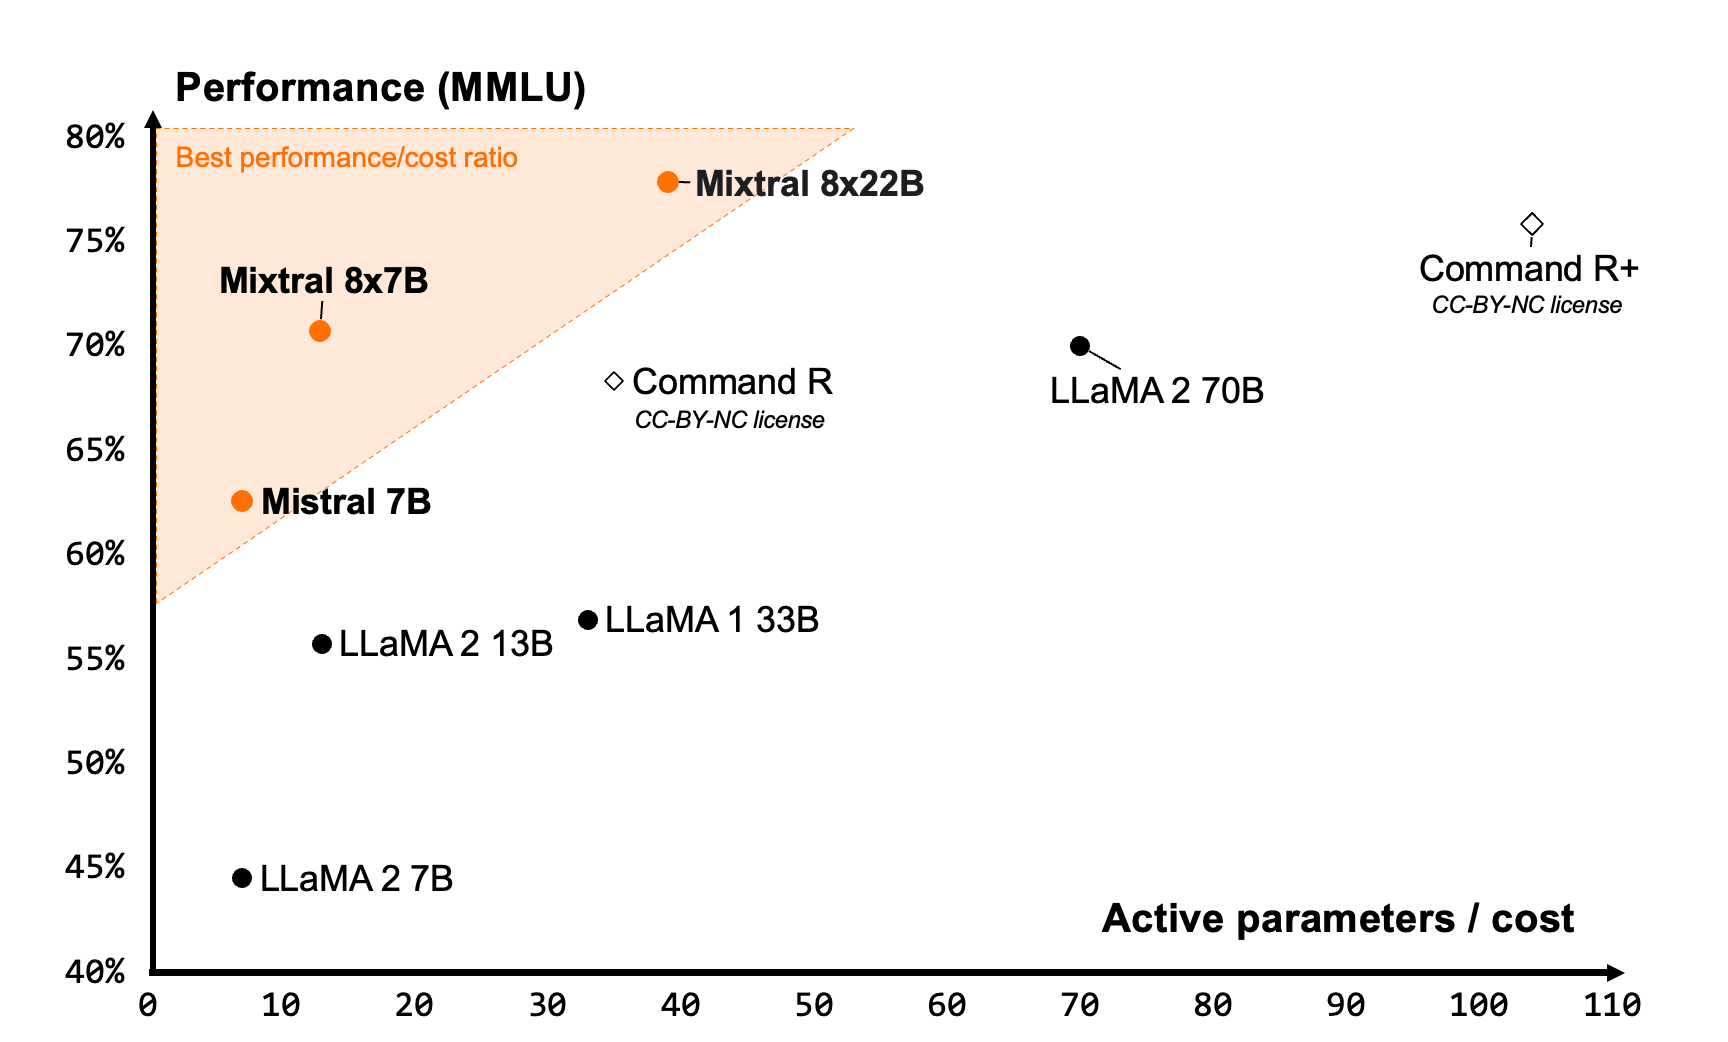

The image above features some of the leading open-source LLMs and the number of active parameters they require to reach a certain performance threshold. Mixtral is right in the top left corner, which means it uses significantly less parameters to reach +75% performance than a model in the same ballpark - Command R+.

Even though Mixtral 8X22B has 141 billion parameters, its sparse activation pattern uses only 39 billion parameters during inference. This makes it not only high-performant, but faster than any 70-billion parameter dense model like Llama 70B. It also features a 64k-token context window, which is very rare for today's open-source LLMs. 

The model also comes with the most permissive open-source license - Apache 2.0. Combined with the low cost required to run it, Mixtral 8X22B is an excellent choice for fine-tuning scenarios. 

## How about benchmarks?

Mixtral 8x22B passes standard industry benchmarks with flying colors. In most of the benchmarks, the emphasis was given on how well the model had performed compared to its main similar alternatives:

- Llama 70B: Offered by Meta, suitable for large-scale language modeling, text generation and dialogue systems.
- Command R+: 104B parameter model offered by Cohere, specifically designed for long-context tasks and RAG pipelines.

For example, Mixtral 8X22B is fluent in five languages: English, German, French, Spanish and Italian. The proof can be seen from the following table:

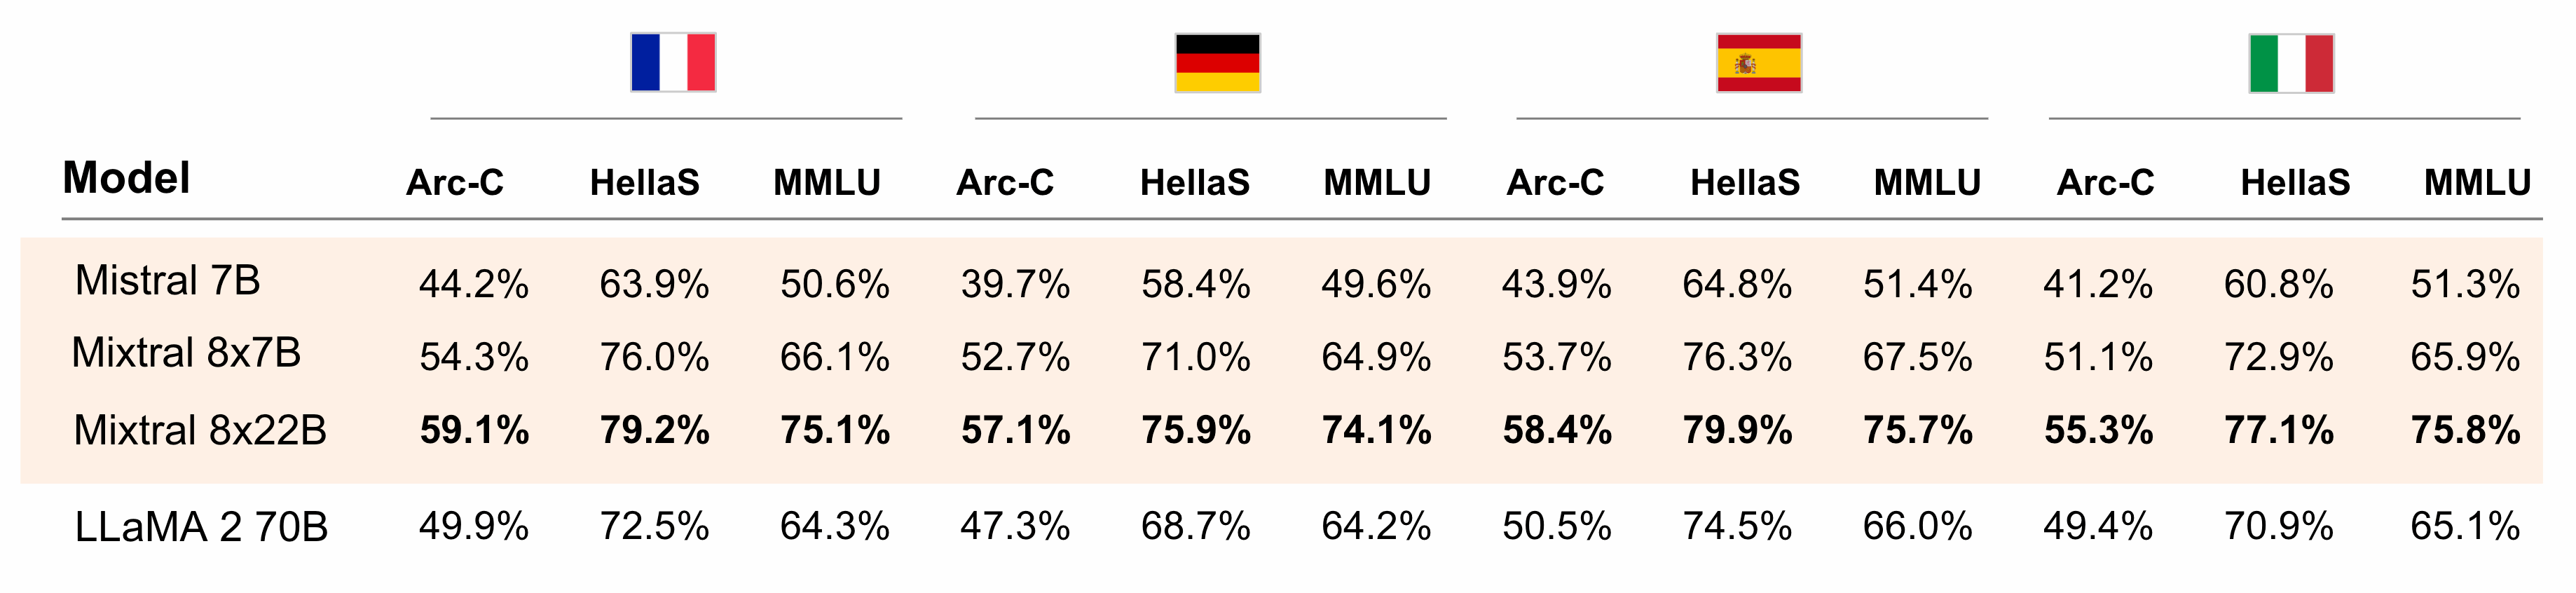

It beats Llama 2 70B on language tasks across three benchmarks:
- Arc-C: The Abstraction and Reasoning Corpus (ARC) benchmark is designed to measure AI performance in common sense reasoning.
- HellaS: HellaSwag is another benchmark for common sense reasoning.
- MMLU: Massive Multitask Language Understanding bechmark.


As for pure common sense reasoning questions in English, Mixtral performs admirably again:

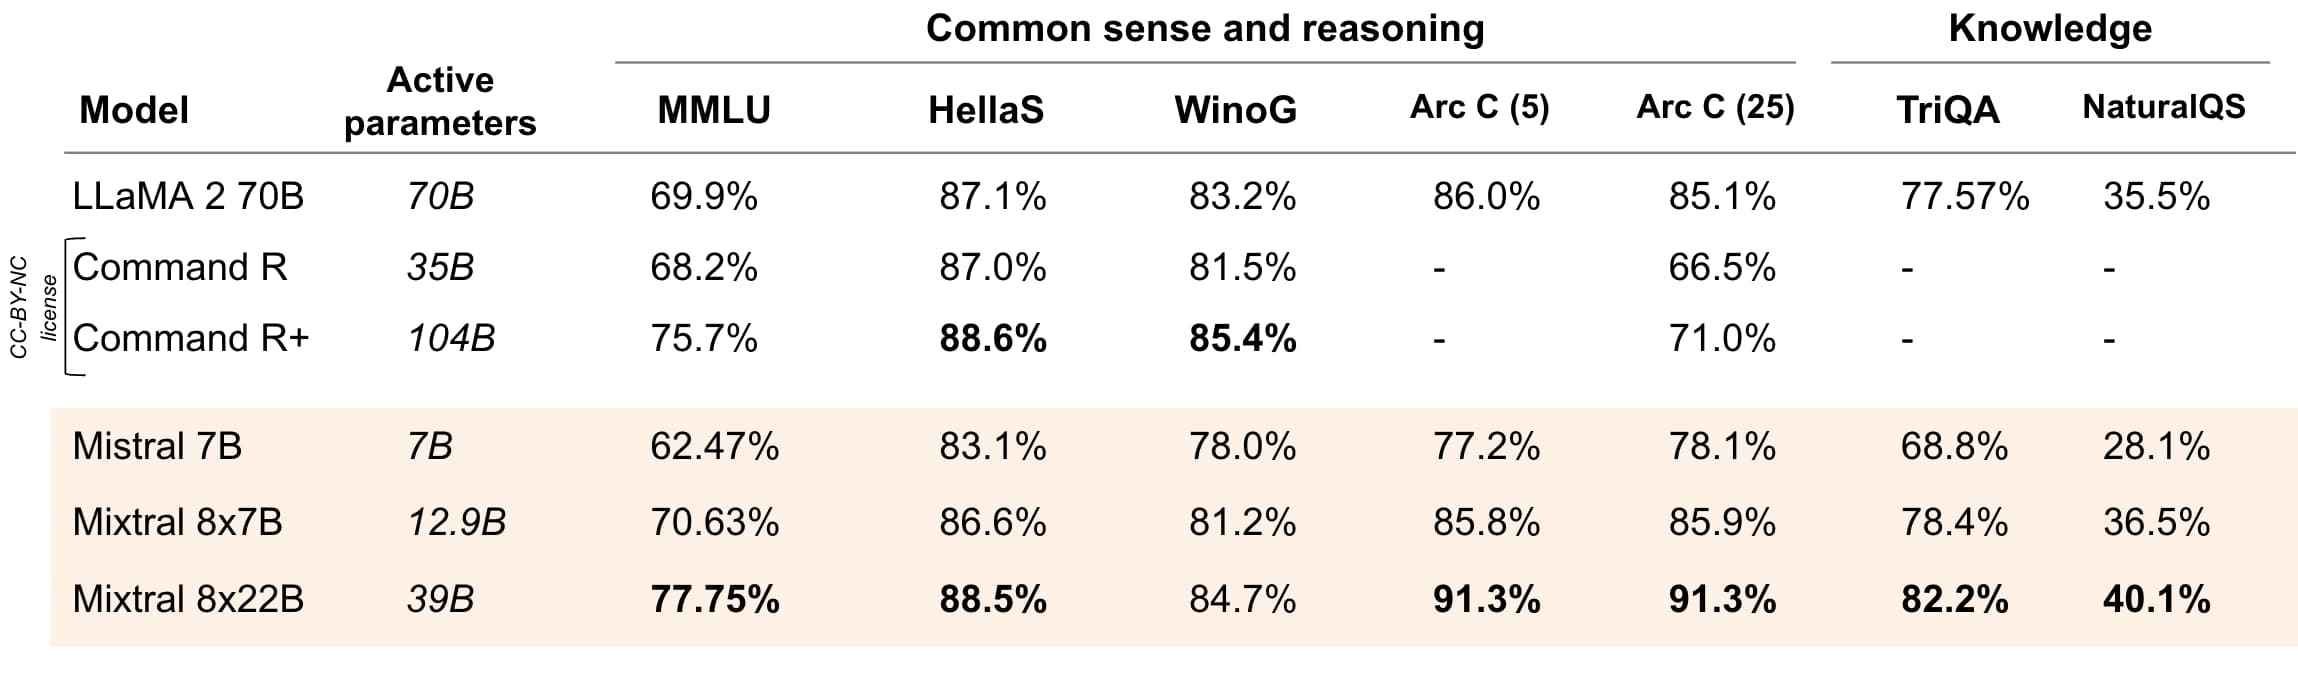

It is slightly worse than Command R+ in two benchmarks but in others, it is significantly better. 

And its most defining point, Mixtral crushes all its alternatives in math and coding tasks:

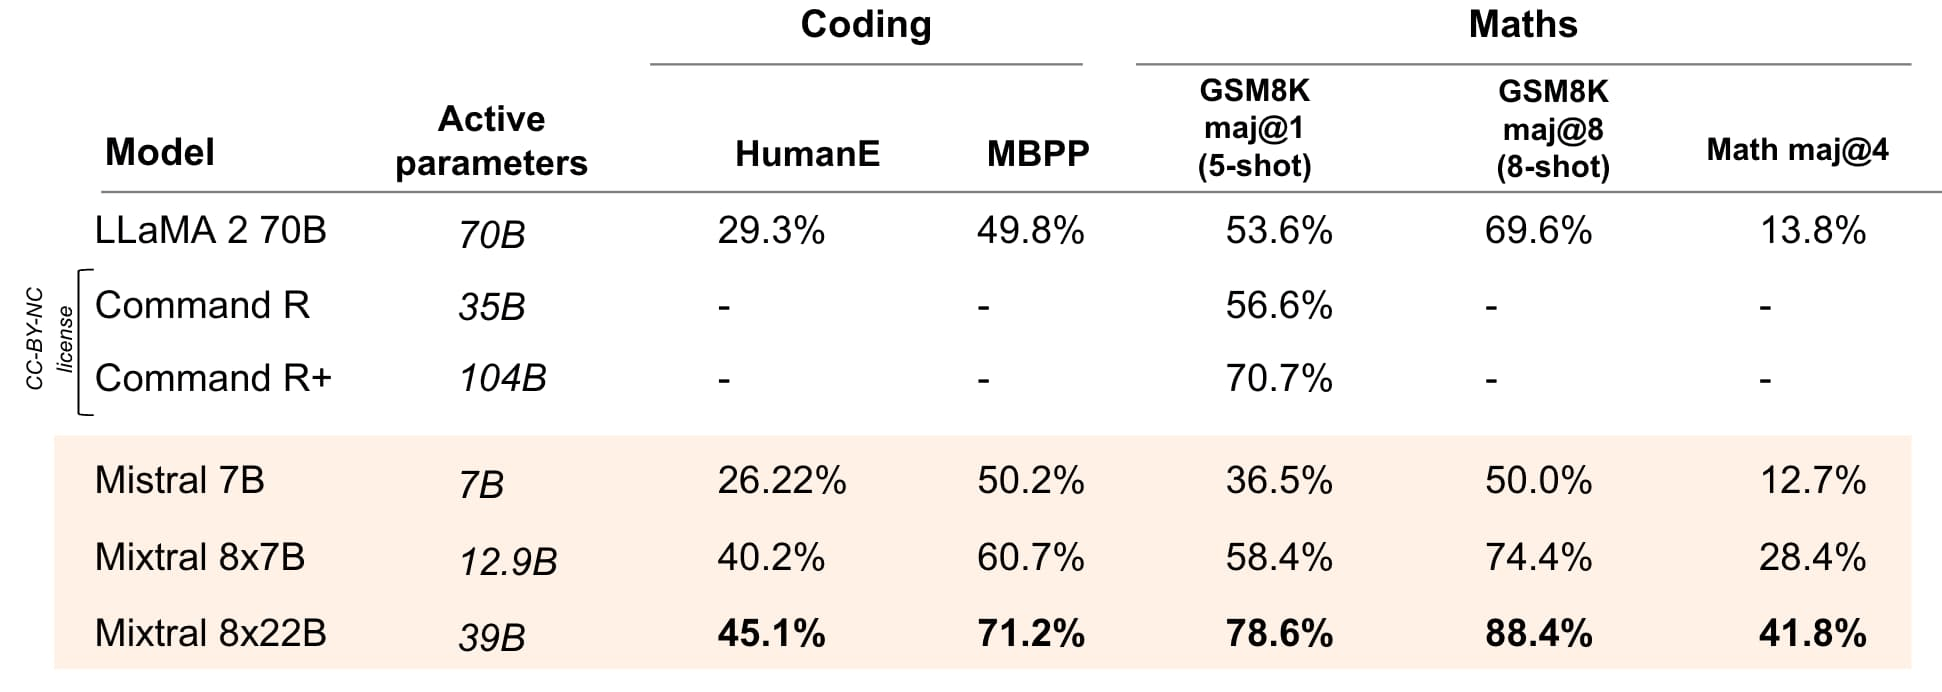

Now, let's take a look at how Mixtral achieves its state-of-the-art performance.

## The architecture behind Mixtral 8X22B - SMoE explained

To understand the sparse mixture of experts (SMoE) architecture better, we will use a simply analogy. Let's say 100 people are working on a project.

- __Traditional models__: The entire team (all model parameters) analyzes all the project information and everybody works on every task together.
- __SMoE architecture__: A smart team leader assigns tasks based on expertise. The leader (called a router or gating network) directs each piece of information (token) to a small group of specialists (experts) best suited to handle it. Only the right experts work on the problem, making the process much faster and more focused.

SMoE models have the following key components:

1. __Experts__: smaller neural networks compared to the full model. Mixtral uses 8 experts that each handle specific type of information or task. For example, one of the experts may handle math and logic queries, while another might handle French.
2. __Router (gating network)__: The gating network determines which tokens are sent to which expert. The router typically uses a small neural network itself to consider factors like the content of the token and the current context to make the decision. How to route a token to an expert is one of the big decisions when working with any MoE model.
3. __Aggregation__: Once the experts process their assigned tokens, their outputs are combined. This can be done in various ways such as plain averaging or using a more complex weighting strategy.

This type of model structure has many benefits:
- __Efficiency__: By only activating a small subset of experts for each input, SMoE reduces computational costs and improves processing speed.
- __Scalability__: You can easily add more experts to the pool without significantly impacting training or inference time. This allows you to build very large models with high capacity.
- __Accuracy__: Specializing experts to certain tasks can lead to better performance compared to a single, monolithic network. The benchmarks showed that Mixtral was particularly good at language, math and coding tasks and I guess, we can credit these achievements to its particular experts.

Since they are new, SMoE models present unique challenges that aren't effectively tackled yet:
- __Training complexity__: Training an SMoE model can be very challenging due to the added complexity of the gating network and expert coordination.
- __Finding the right experts__: Deciding on the appropriate number and type of experts is crucial for optimal performance.
- __Heavy on memory__: due to its architecture, all parameters of the model must be loaded into memory during inference, taking up all of your GPU vRAM. To run inference with Mixtral 8X22B, you need a GPU with at least 300GB of memory.

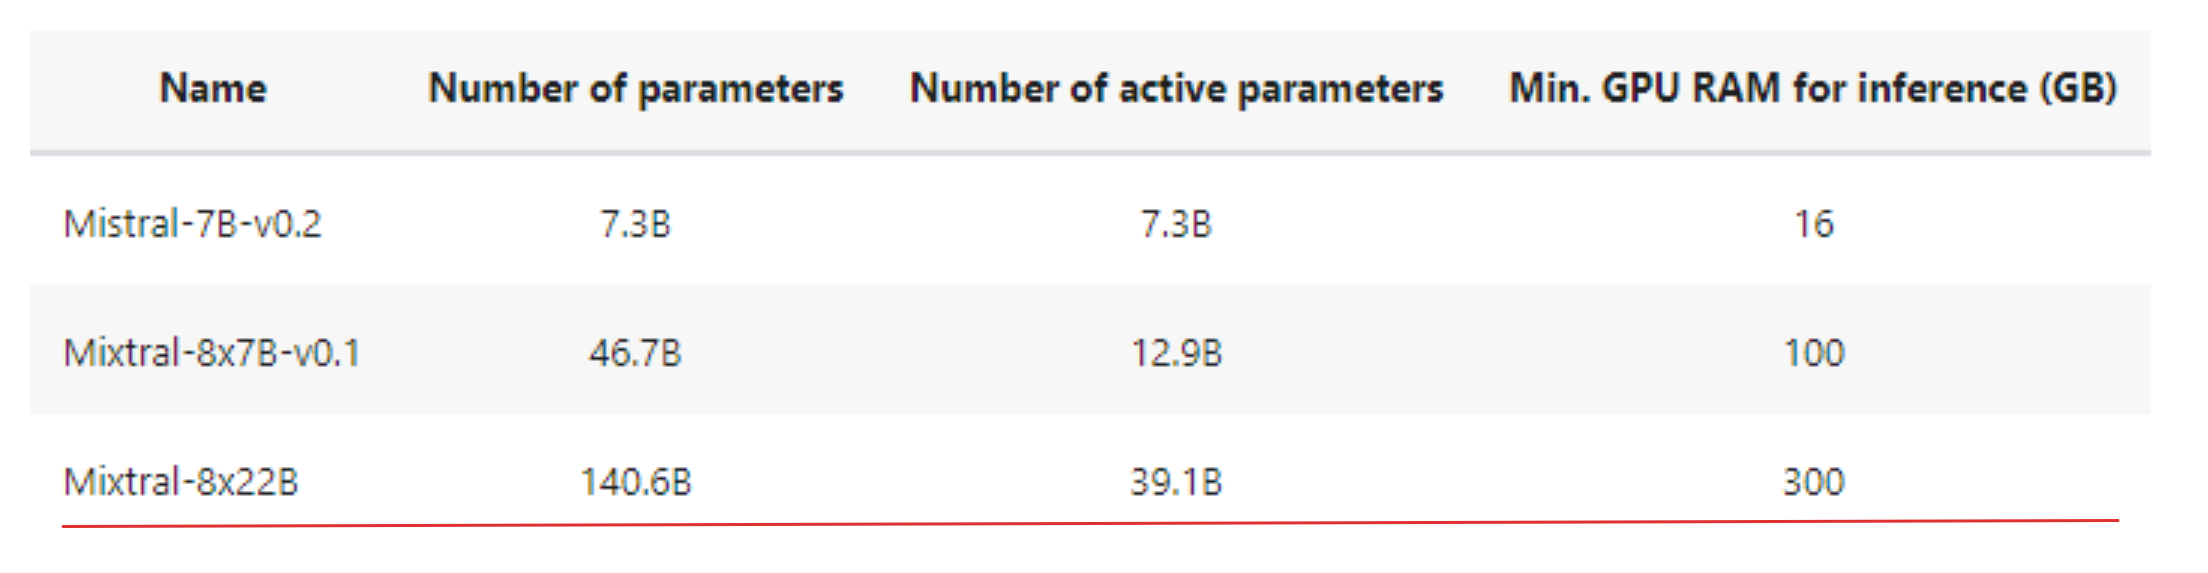

In summary, since the scale of the model is one of the most important factors for better model quality, reducing the number of active parameters makes models significantly cheaper and faster to train. Training a larger model for a fewer steps is better than training a small model for more steps when compute budget is constrained. 

Mixture of experts architectures allow models to be trained with far less compute, which allows you to scale up model size dramatically under the same budget as a dense model. Any SMoE model should achieve the same quality as its dense counterpart much faster during pretraining. 

## Getting started with Mixtral 8x22B

In this section, we will learn how to start using the Mixtral 8X22B model using the Mistral AI API. Since the model is about 0 gigabytes in size and requires a 300 gigabyte GPU, it will be a wee bit hard and expensive to run it on any cloud provider, let alone on consumer hardware. 

Let's go.

### Account setup

Mistral AI requires you to create an account and enter billing information to get your API key. So, please head over to [mistral.ai](mistral.ai) to create your account. Once you log in with your credentials, you will be directed to your Mistral console at [console.mistral.ai](console.mistral.ai). 


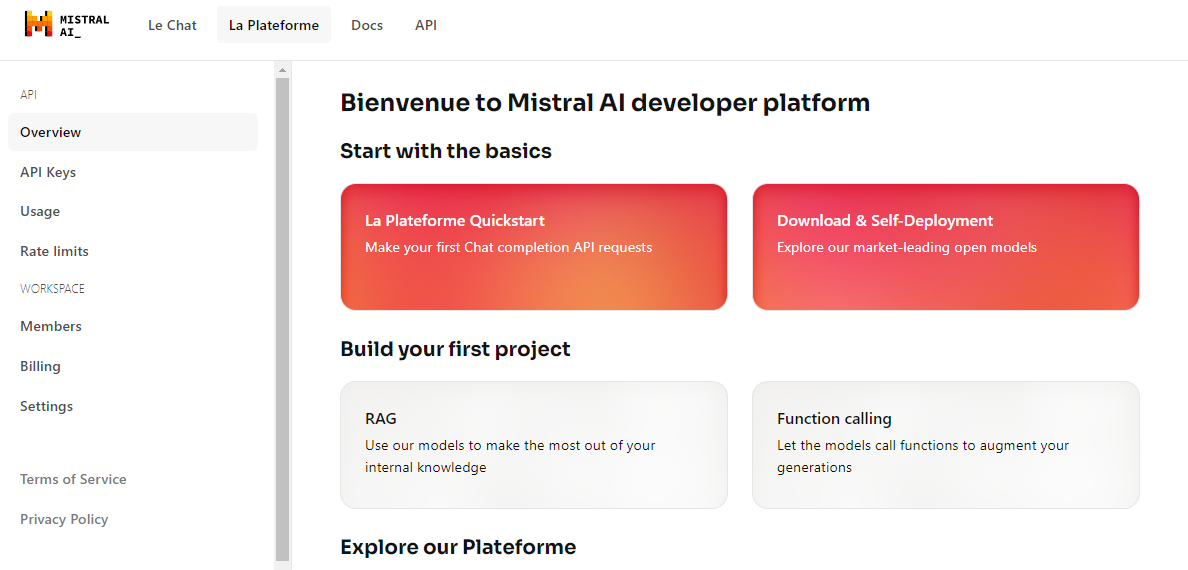

Head over to "Billing" and add you payment information:

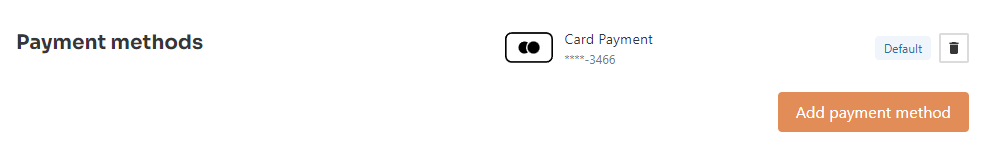

Then, add credits for a few dollars like I did:

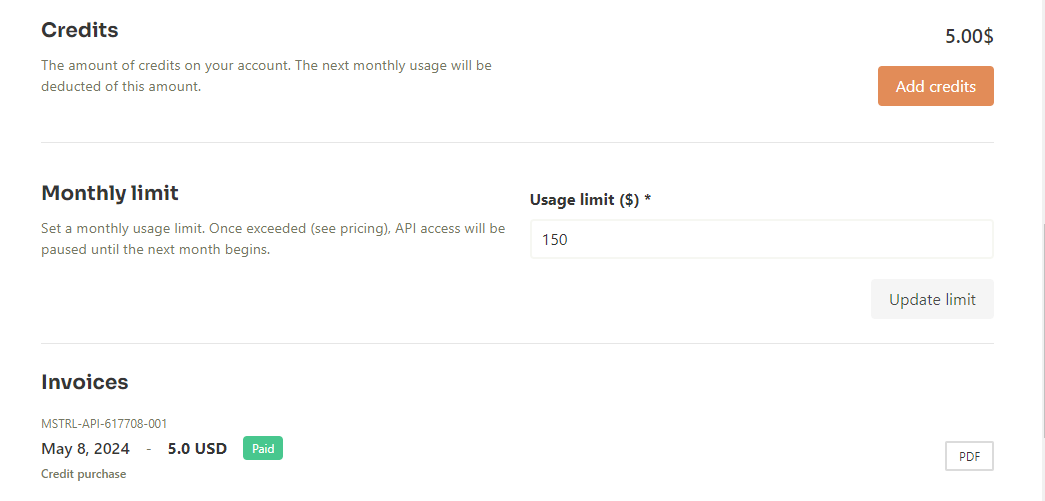

This will allow you to generate an API key from the "API KEYS" section:

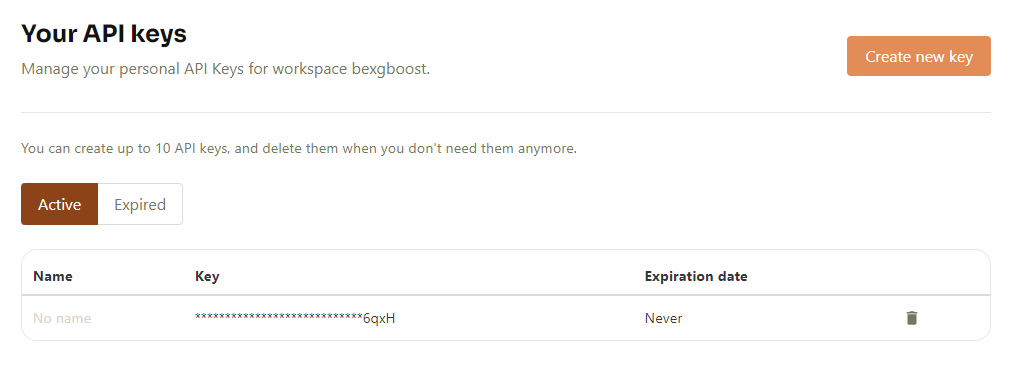

When you create a key, it will displayed only once, so save it somewhere safe. We will use it in the next section.

### Environment setup

Now, let's set up a virtual environment to run Mistral API:

```bash
$ conda env create -n mistral python==3.8 -y
$ conda activate mistral
```

Then, we can install `mistralai` Python package along with a couple of other essentials:

```python
$ pip install mistralai
$ pip install python-dotenv ipykernel
$ ipython kernel install --user --name=mistral
```

The last command adds the newly-installed Conda environment as a Jupyter kernel. 

We will use `python-dotenv` package to safely read our Mistral API key from a notebook. To do so, create a `.env` file in your working directory:

```
$ touch .env
```

Then, edit the file so that it lists your key in the following syntax:

```
MISTRAL_API_KEY=YOUR_KEY_HERE
```

Also, make sure to add the `.env` file to `.gitignore` so that it isn't accidentally leaked to GitHub:

```
$ echo ".env" >> .gitignore
```

Now, to read the key we just saved, we can use the `load_dotenv` function along with the `os` library:

In [45]:
import os

from dotenv import load_dotenv

load_dotenv()

api_key = os.getenv("MISTRAL_API_KEY")

### Using a chat client

Finally, to interact with any Mistral model, we will use the `MistralClient` object:

In [49]:
from mistralai.client import MistralClient

client = MistralClient(api_key=api_key)

The client requires our API key to connect to Mistral servers. Then, we will import the `ChatMessage` class to hold dialogues with Mistral models:

In [50]:
from mistralai.models.chat_completion import ChatMessage

model = "open-mixtral-8x22b"

message = "Who is the best French football player of all time?"

chat_response = client.chat(
    model=model,
    messages=[ChatMessage(role="user", content=message)],
)

print(chat_response.choices[0].message.content[:300])

Determining the "best" French football player of all time can be subjective and depends on personal opinion. However, one player who is often mentioned in this context is Zinedine Zidane. He had an impressive career both for the French national team and at club level. He was a key player in France's


We got a response - so, everything is set up correctly. 

A `ChatResponse` object usually holds more than one answer, so we are selecting the first one and printing a subtext. 

## Practical applications

Beyond plain text generation, you can do much more with Mixtral:
- Generating embeddings
- Creating a paraphrase detector
- A full RAG pipeline
- Function calling

and so on. We will look at each these scenarios one by one.

### Text generation

In the previous section, we were able to generate a large bulk of text from the chat client. In some cases, when we guess that the answer might be longer, it makes sense to stream the output just like in ChatGPT. We can do that too:

In [ ]:
messages = [ChatMessage(role="user", content="What led to Zidane's ban from football?")]

# With streaming
stream_response = client.chat_stream(model=model, messages=messages)

for chunk in stream_response:
    print(chunk.choices[0].delta.content, end="")

Instead of the `chat` method, we can use `chat_stream` which gives the answer on demand, in chunks:

![](images/zidane.gif)

### Generating embeddings

Embeddings are key components of LLM applications. An embedding is a vector representation of text that capture its semantic meaning through their position in a high dimensional vector space. If the distance between two embeddings are close, that means they are similar in meaning. For example, the word _apple_ will be closer to _orange_ than to _keyboard_. 

Mistral API offers state-of-the-art embedding models for text. Let's briefly look at how they work:

In [10]:
to_embed = ["Is Messi better than Zidane?", "How about Ronaldo?"]

embeddings_batch_response = client.embeddings(
    model="mistral-embed",
    input=to_embed,
)

type(embeddings_batch_response)

mistralai.models.embeddings.EmbeddingResponse

First, we create a list of sentences to be embedded in `to_embed`. Then, we will pas them to `embeddings` method along with an embedding model name - `mistral-embed`. The result is an `EmbeddingResponse` object. When we print the length of its `data`  attribute, we will see that it has two vectors for the two embedded sentences:

In [11]:
len(embeddings_batch_response.data)

2

We can also get the dimensions of the vectors:

In [12]:
first_sentence = embeddings_batch_response.data[0]

len(first_sentence.embedding)  # Embedding dimension

1024

We have got a result of 1024, which means Mistral embeds any text, regardless of its length into a 1024-dimensional vector. 

Note that higher dimensional embeddings might better capture text information and improve performance but they require more compute for hosting and inference.

Although we didn't use the Mixtral 8X22B model in the section, understanding embeddings will be important when we create a simple RAG pipeline. 

### Paraphrase detection using embeddings

As we stated earlier, if the distance between two embeddings is close, then they might be close in meaning. Extending this idea, we build a primitive paraphrase detector because if the distance between two sentences is short, there is a chance they are paraphrases.

First, we will create a function that returns the embedding vector for a given input:

In [52]:
def get_text_embedding(input, client):
    embeddings_batch_response = client.embeddings(model="mistral-embed", input=input)

    return embeddings_batch_response.data[0].embedding

Then, we will define the list of sentences we want to check against each other for paraphrasing and get their embeddings:

In [53]:
sentences = [
    "What led to Zidane's ban from football?",
    "This is a totally different sentence.",
    "What caused Zidane to get banned from football?",
]

sentence_embeddings = [get_text_embedding(t, client) for t in sentences]

Then, we will create all possible two-pair combinations of the sentences using `itertools`:

In [57]:
import itertools

sentence_embeddings_pairs = list(itertools.combinations(sentence_embeddings, 2))
sentence_pairs = list(itertools.combinations(sentences, 2))

print(sentence_pairs[0])

("What led to Zidane's ban from football?", 'This is a totally different sentence.')


Then, we will print the euclidean distance between each sentence embedding pair and print the results:

In [65]:
from sklearn.metrics.pairwise import euclidean_distances

for s, e in zip(sentence_pairs, sentence_embeddings_pairs):
    distance = euclidean_distances([e[0]], [e[1]])

    print(s, distance)

("What led to Zidane's ban from football?", 'This is a totally different sentence.') [[0.84503319]]
("What led to Zidane's ban from football?", 'What caused Zidane to get banned from football?') [[0.28662641]]
('This is a totally different sentence.', 'What caused Zidane to get banned from football?') [[0.83794058]]


The distance between the second pair is close, which indicates they might be paraphrases of each other.

### Using Mixtral 8X22B in a RAG pipeline

LLMs are trained on mounds and mounds of data but they aren't always up-to-date and don't have access to your private datasets. Fine-tuning them is too expensive if you just want the model to answer questions on other existing datasets.

That's why Retrieval Augmented Generation (RAG) pipelines burst in popularity. Without costly fine-tuning, you can teach an LLM to process custom information that wasn't part of its training and answer questions about it. 

In this section, we will build a basic RAG pipeline that learns the information from yesterday's news in this [1440 article](https://news.join1440.com/t/j-e-gluitld-dudiuljity-dh/). I've saved part of the news to this text file, which you can download from GitHub or just copy/paste and save into a file named `news_piece.txt`.

In [71]:
from pathlib import Path

file = Path("news_piece.txt")
text = file.read_text()

Then, we will split the document into chunks as RAG systems perform better when text is in chunks. In this example, we will split the text into chunks of 512 characters each:

In [72]:
chunk_size = 512
chunks = [text[i : i + chunk_size] for i in range(0, len(text), chunk_size)]

len(chunks)

4

Then, we will get the embeddings of each chunk using the `get_text_embedding` function from the last section:

In [73]:
text_embeddings = np.array([get_text_embedding(chunk, client) for chunk in chunks])

```
$ pip install faiss-cpu
```

Next, it is common practice to store embeddings in a vector database for efficient processing and retrieval. There are many options out there for vector databases. We will use `faiss` - an open-source database for similarity search.

In [74]:
import faiss  # pip install faiss

d = text_embeddings.shape[1]
index = faiss.IndexFlatL2(d)

index.add(text_embeddings)

`index` is an instance of an `Index` class which defines the structure of our database. `d` is for the dimension of the embedding space. 

Running the `add` method adds the information from our document to the vector database, which means we can ask questions about it. But before we do that, any questions we have must be converted to an embedding as well:

In [85]:
import numpy as np

questions = [
    "How much is Microsoft going to spend for its new data center?",
    "When did FTX collapse?",
]

question_embeddings = np.array([get_text_embedding(q, client) for q in questions])

Then, we can feed the `question_embeddings` array to the `search` method of the `Index` object:

In [87]:
D, I = index.search(question_embeddings, k=4)  # distance, index

retrieved_chunk = [chunks[i] for i in I.tolist()[0]]

The `search` method returns the vectors that most likely hold the answer to our questions:

In [88]:
len(retrieved_chunk)

4

In [90]:
print(retrieved_chunk[2])

ay defrauded investors in full and provide the vast majority with interest. The failed cryptocurrency exchange platform filed its proposal late Tuesday to a federal bankruptcy court for approval.

Since FTX collapsed in 2022, CEO John Ray III (see previous write-up) has worked to track down more than $8B in missing assets to repay an estimated $11.2B owed to creditors. This week, Ray said the company has recovered between $14.5B and $16.3B, with much of the funds tied to government-seized FTX properties or 


Now, we can pass this text as context for the Mixtral 8X22B model and ask our questions about it. Let's build the prompt:

In [91]:
prompt = f"""
Context information is below.
---------------------
{retrieved_chunk}
---------------------
Given the context information and not prior knowledge, answer the query.
Query: {questions}
Answer:
"""

Now, we can pass it to the model using the `client`:

In [92]:
chat_response = client.chat(
    model=model,  # Mixtral 8x22B
    messages=[ChatMessage(role="user", content=prompt)],
)

print(chat_response.choices[0].message.content)

Microsoft will spend $3 billion for its new data center in Racine, Wisconsin. FTX collapsed in 2022.


The answers are correct!

We've built a very basic RAG pipeline. In practice, RAG pipelines are very powerful - they can handle variety of input (text, image, audio, video) and can work on a massive scale as compared to our version that handled a single text file.

If you want to learn how to build powerful RAG pipelines, check [this DataCamp tutorial](https://www.datacamp.com/tutorial/how-to-build-llm-applications-with-langchain) on LangChain.

### Function calling

One of the native capabilities of Mixtral 8X22B model is function calling. In the context of LLMs, function calling is a technique that allows LLMs to understand and respond to prompts in a way that triggers the execution of specific functions. Here's a breakdown of what that means:

- Standard LLM response: LLMs generate text for a prompt based on their training data. This response is usually unpredictable and unstructured.
- Function calling with Mixtral: With function calling, Mixtral 8X22B can be taught to invoke predefined custom functions to structure their output based on prompt type. Mixtral typically returns output in structured JSON format, which you can define beforehand. This makes its responses much more predictable and structured.

Demonstrating how function calling works is beyond the scope of this article. However, you can check out [this page of Mistral AI docs](https://docs.mistral.ai/capabilities/function_calling/) to see it in action. 

## Conclusion

In this article, we have learned about Mixtral 8X22B model released by Mistral AI in April 2024. Due to its architectural advantages, it is now one of the leading open-source LLMs, beating popular models such as Llama 2 and Command R+ across many benchmarks. 

Apart from its architecture details, we have learned how to use in a few practical scenarios such as text generation, paraphrase detection and creating a RAG pipeline. If you want to unlock Mixtral 8X22B model's full potential, check out these related resources:

- [Guide to Working With the Mistral Large Model](https://www.datacamp.com/tutorial/guide-to-working-with-the-mistral-large-model)
- [Large Language Models (LLMs) Concepts Course](https://www.datacamp.com/courses/large-language-models-llms-concepts)
- [How to Train an LLM with Pytorch Tutorial](https://www.datacamp.com/tutorial/how-to-train-a-llm-with-pytorch)
- [Tutorial on How to Fine-tune LLMs](https://www.datacamp.com/tutorial/fine-tuning-large-language-models)

Thank you for reading!